In [34]:
library(randomForest)
library(kernlab)
library(MASS)
library(ggplot2)
library(rpart)
library(class)


1)

# FORWARD RANKING

In [115]:
forward.ranking <- function(x, y, method, verbosity = 0, ...) {
    max.feat <- dim(x)[2]
    num.feat <- 1
    list.feat <- 1:max.feat
    print(dim(x))
    print(length(y))
    # ranking inicial: elijo la variable con menor error de prediccion
    x.train <- matrix(0, dim(x)[1], 1)
    class.error <- double(max.feat)
    # para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
    for (i in 1:max.feat) {
        x.train[, 1] <- x[, i]
        print(dim(x.train))
        print(length(y))
        class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)))
    }

    # guardo la variable con minimo error como primera. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
    list.feat[1] <- which.min(class.error)
    keep.feat <- sort(class.error, decreasing = FALSE, index = T)$ix[-1]
    # armo un dataset con las variables que ya elegi, para ir agregando en cada paso.
    x.prev <- x.train[, 1] <- x[, list.feat[1]]

    if (verbosity > 1) cat("\nFirst feature: ", list.feat[1], "\n")

    # loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
    while (num.feat < max.feat) {
        # class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
        class.error <- double(max.feat - num.feat)
        # para cada variable que me queda, la agrego al dataset del paso anterior, entreno el modelo y le mido el error.
        for (i in 1:(max.feat - num.feat)) {
            x.train <- cbind(x.prev, x[, keep.feat[i]])
            class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)))
        }
        if (verbosity > 2) cat("\nFeatures:\n", keep.feat, "\nErrors:\n", class.error)
        # me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan, y actualizo el dataset de partida de la iteracion.
        best.index <- which.min(class.error)
        list.feat[num.feat + 1] <- keep.feat[best.index]
        if (verbosity > 1) cat("\n---------\nStep ", 1 + num.feat, "\nFeature ", best.index)

        keep.feat <- keep.feat[-best.index]
        if (verbosity > 2) cat("\nNew search list: ", keep.feat)
        num.feat <- num.feat + 1
        x.prev <- x[, list.feat[1:num.feat]]
    }

    search.names <- colnames(x)[list.feat]
    # le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos
    imp <- (max.feat:1) / max.feat
    names(imp) <- search.names

    if (verbosity > 1) {
        cat("\n---------\nFinal ranking ", num.feat, " features.")
        cat("\nFeatures: ", search.names, "\n")
    }

    return(list(ordered.names.list = search.names, ordered.features.list = list.feat, importance = imp))
}


# BACKWARD RANKING

In [67]:
backward.ranking <- function(x, y, method, verbosity = 0, ...) {
    max.feat <- dim(x)[2]
    num.feat <- 0
    list.feat <- c()
    keep.feat <- 1:max.feat
    x.matrix <- as.matrix(x)

    while (num.feat < max.feat - 1) {
        # class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
        class.error <- double(max.feat - num.feat)
        # para cada variable que me queda, la agrego al dataset del paso anterior, entreno el modelo y le mido el error.
        for (i in 1:(max.feat - num.feat)) {
            index <- c(list.feat, keep.feat[i])
            x.train <- x.matrix[, -c(index), drop = FALSE]
            class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)))
        }
        if (verbosity > 2) cat("\nFeatures:\n", keep.feat, "\nErrors:\n", class.error)
        # me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan, y actualizo el dataset de partida de la iteracion.
        best.index <- which.min(class.error)
        list.feat[num.feat + 1] <- keep.feat[best.index]
        if (verbosity > 1) cat("\n---------\nStep ", 1 + num.feat, "\nFeature ", best.index)

        keep.feat <- keep.feat[-best.index]
        if (verbosity > 2) cat("\nNew search list: ", keep.feat)
        num.feat <- num.feat + 1
    }
    num.feat <- num.feat + 1
    list.feat[num.feat] <- keep.feat[1]


    list.feat <- rev(list.feat) # Invierto list.feat porque las mas importantes las elimine ultimas
    search.names <- colnames(x)[list.feat]
    imp <- (max.feat:1) / max.feat
    names(imp) <- search.names

    if (verbosity > 1) {
        cat("\n---------\nFinal ranking ", num.feat, " features.")
        cat("\nFeatures: ", search.names, "\n")
    }

    return(list(ordered.names.list = search.names, ordered.features.list = list.feat, importance = imp))
}


# Filter con test no-paramétrico (Kruskal-Wallis)

In [37]:
kruskal.ranking <- function(x, y) {
    max.feat <- dim(x)[2]
    list.feat <- c()
    class.error <- double(max.feat)

    for (i in 1:max.feat) class.error[i] <- kruskal.test(x[, i], y)$p.value

    list.feat <- sort(class.error, decreasing = FALSE, index = T)$ix

    search.names <- colnames(x)[list.feat]
    imp <- (max.feat:1) / max.feat
    names(imp) <- colnames(x)[list.feat]

    return(list(ordered.names.list = search.names, ordered.features.list = list.feat, importance = imp))
}


# RFE

In [38]:
rfe.ranking <- function(x, y, method, ...) {
    max.feat <- dim(x)[2]
    num.feat <- 1
    list.feat <- c()
    keep.feat <- 1:max.feat
    x.matrix <- as.matrix(x)

    while (num.feat < max.feat) {
        if (num.feat == 1) {
            ranking <- do.call(method, c(list(x.matrix, y), list(...)))
        } else {
            ranking <- do.call(method, c(list(x.matrix[, -c(list.feat), drop = FALSE], y), list(...)))
        }

        # me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan, y actualizo el dataset de partida de la iteracion.
        best.index <- ranking$feats[1]
        list.feat[num.feat] <- keep.feat[best.index]
        keep.feat <- keep.feat[-best.index]
        num.feat <- num.feat + 1
    }
    # num.feat <- num.feat
    list.feat[num.feat] <- keep.feat[1]


    list.feat <- rev(list.feat) # Invierto list.feat porque las mas importantes las elimine ultimas
    search.names <- colnames(x)[list.feat]
    imp <- (max.feat:1) / max.feat
    names(imp) <- search.names

    return(list(ordered.names.list = search.names, ordered.features.list = list.feat, importance = imp))
}


#---------------------------------------------------------------------------
# random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------

In [39]:
rf.est <- function(x.train, y, equalize.classes = TRUE, tot.trees = 500, mtry = 0) {
    if (mtry < 1) mtry <- floor(sqrt(dim(x.train)[2]))
    prop.samples <- table(y)
    if (equalize.classes) prop.samples <- rep(min(prop.samples), length(prop.samples))
    return(randomForest(x.train, y, mtry = mtry, ntree = tot.trees, sampsize = prop.samples)$err.rate[tot.trees])
}


#---------------------------------------------------------------------------
# LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------

In [40]:
lda.est <- function(x.train, y) {
    m.lda <- lda(x.train, y, CV = TRUE)
    return(error.rate(y, m.lda$class))
}
error.rate <- function(dataA, dataB) sum(dataA != dataB) / length(dataB)


#---------------------------------------------------------------------------
# SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------

In [41]:
svm.est <- function(x.train, y, type = "C-svc", kernel = "vanilladot", C = 1, cross = 4) {
    return(ksvm(x.train, y, type = type, kernel = kernel, C = C, cross = cross)@cross)
}


#---------------------------------------------------------------------------
# random forest ranking method for rfe.
#---------------------------------------------------------------------------

In [42]:
imp.rf <- function(x.train, y, equalize.classes = TRUE, tot.trees = 500, mtry = 0) {
    if (mtry < 1) mtry <- floor(sqrt(dim(x.train)[2]))
    prop.samples <- table(y)
    if (equalize.classes) prop.samples <- rep(min(prop.samples), length(prop.samples))

    m.rf <- randomForest(x.train, y, ntree = tot.trees, mtry = mtry, sampsize = prop.samples, importance = TRUE)
    imp.mat <- importance(m.rf)
    imp.col <- dim(imp.mat)[2] - 1
    rank.list <- sort(imp.mat[, imp.col], decreasing = FALSE, index = T)
    return(list(feats = rank.list$ix, imp = rank.list$x))
}


#---------------------------------------------------------------------------
# linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------

In [43]:
imp.linsvm <- function(x.train, y, C = 100) {
    num.feat <- dim(x.train)[2]
    tot.problems <- nlevels(y) * (nlevels(y) - 1) / 2

    m.svm <- ksvm(as.matrix(x.train), y, type = "C-svc", kernel = "vanilladot", C = C)

    w <- rep(0.0, num.feat)
    for (i in 1:tot.problems) {
        for (feat in 1:num.feat) {
            w[feat] <- w[feat] + abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][, feat])
        }
    }
    rank.list <- sort(w, decreasing = FALSE, index = T)
    return(list(feats = rank.list$ix, imp = rank.list$x))
}


## Creando datosA y datosB

In [44]:
crea.ruido.unif <- function(n = 100, d = 2) {
    x <- runif(2 * n * d, min = -1) # genero los datos
    dim(x) <- c(2 * n, d)
    return(cbind(as.data.frame(x), y = factor(rep(c(-1, 1), each = n)))) # le agrego la clase
}

# datosA
d <- 10
n <- 1000
datos <- crea.ruido.unif(n = n, d = d)

# tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle <- sample(1:dim(datos)[1])
sub <- shuffle[1:dim(datos)[1] * 0.5]
datos[sub, d + 1] <- sign(datos[sub, 8])
# tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub <- shuffle[(dim(datos)[1] * 0.5):(dim(datos)[1] * 0.7)]
datos[sub, d + 1] <- sign(datos[sub, 6])
# tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub <- shuffle[(dim(datos)[1] * 0.7):(dim(datos)[1] * 0.8)]
datos[sub, d + 1] <- sign(datos[sub, 4])
# tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub <- shuffle[(dim(datos)[1] * 0.8):(dim(datos)[1] * 0.85)]
datos[sub, d + 1] <- sign(datos[sub, 2])
datos[, d + 1] <- factor(datos[, d + 1])

datosA <- datos

# datosB
# generar n=100,d=8
d <- 8
n <- 1000
datos <- crea.ruido.unif(n = n, d = d)
# hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[, d + 1] <- sign(datos[, 1] * datos[, 2])
# hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle <- sample(1:dim(datos)[1])
sub <- shuffle[1:dim(datos)[1] * 0.5]
datos[sub, 3] <- abs(datos[sub, 3]) * datos[sub, d + 1]
shuffle <- sample(1:dim(datos)[1])
sub <- shuffle[1:dim(datos)[1] * 0.5]
datos[sub, 4] <- abs(datos[sub, 4]) * datos[sub, d + 1]
datos[, d + 1] <- factor(datos[, d + 1])

datosB <- datos


2)

### Datos A

In [45]:
feat.a <- 10
trainA <- datosA[, 1:feat.a, drop = FALSE]
classA <- datosA[, feat.a + 1]
#  print(dim(trainA))
#     print(classA)
fr.rf.a <- forward.ranking(trainA, classA, method = "rf.est", tot.trees = 100, equalize.classes = F)
fr.lda.a <- forward.ranking(trainA, classA, method = "lda.est")
invisible(capture.output(fr.svm.a <- forward.ranking(trainA, classA, method = "svm.est")))
br.rf.a <- backward.ranking(trainA, classA, method = "rf.est", tot.trees = 100, equalize.classes = F)
br.lda.a <- backward.ranking(trainA, classA, method = "lda.est")
invisible(capture.output(br.svm.a <- backward.ranking(trainA, classA, method = "svm.est")))
kruskal.a <- kruskal.ranking(trainA, classA)
rfe.rf.a <- rfe.ranking(trainA, classA, method = "imp.rf")
invisible(capture.output(rfe.svm.a <- rfe.ranking(trainA, classA, method = "imp.linsvm")))


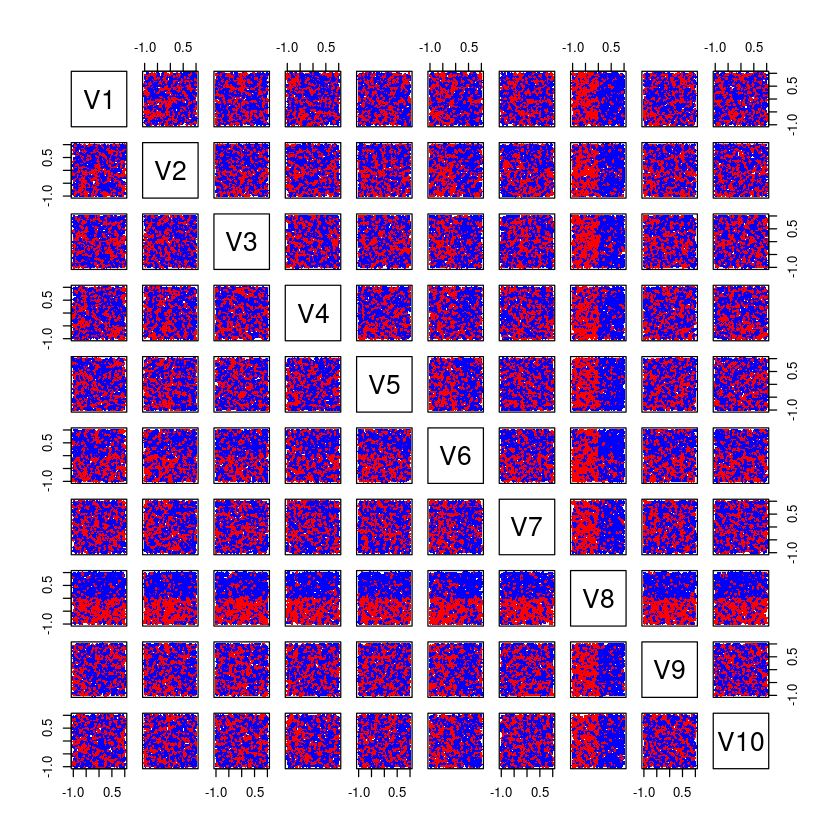

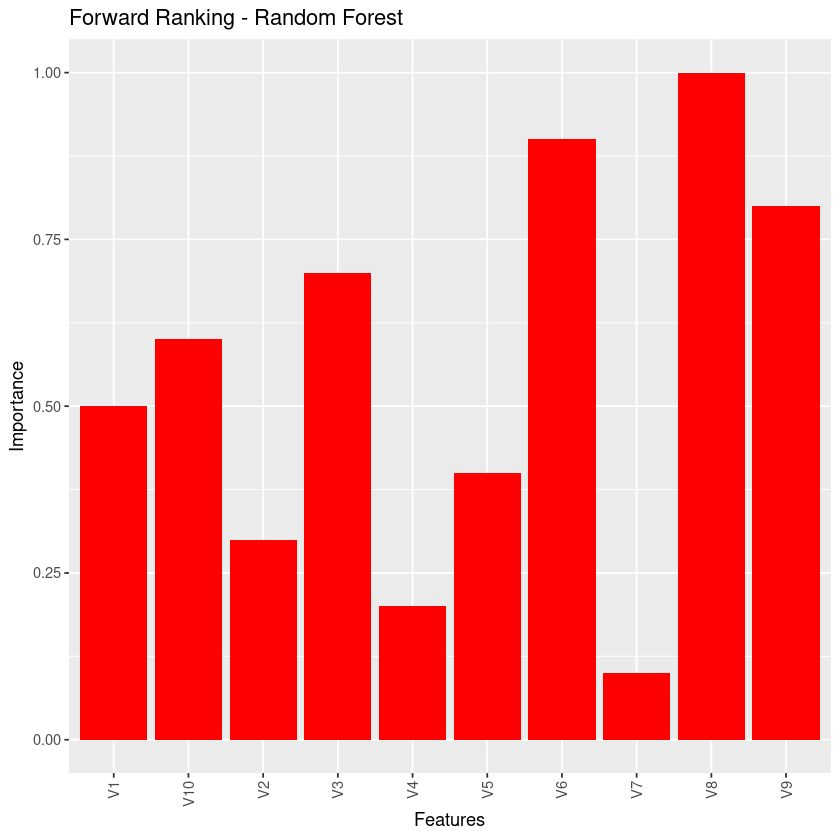

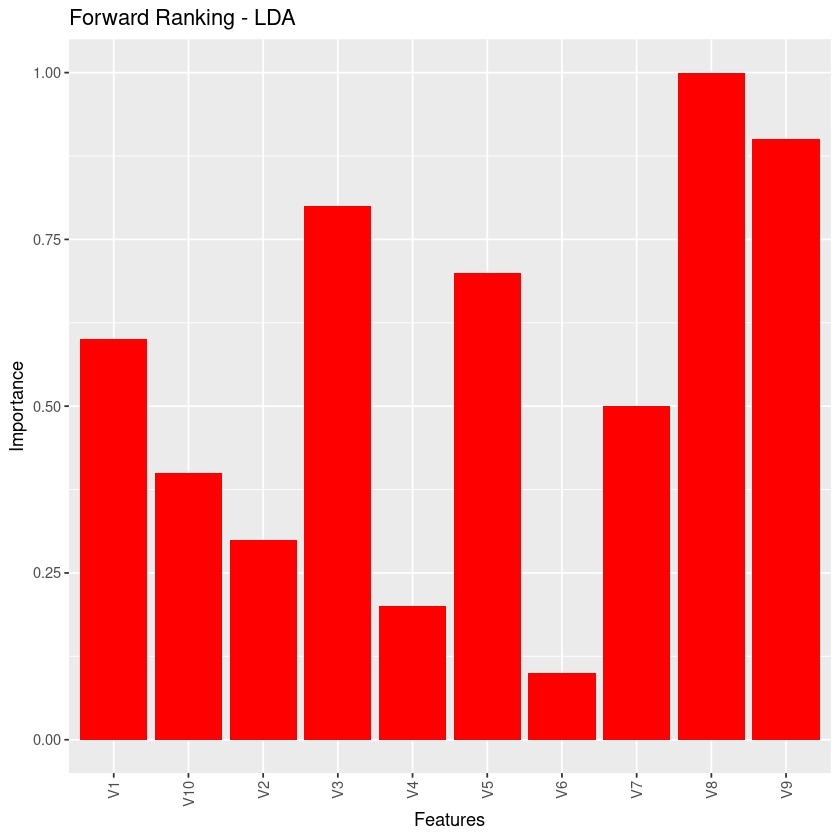

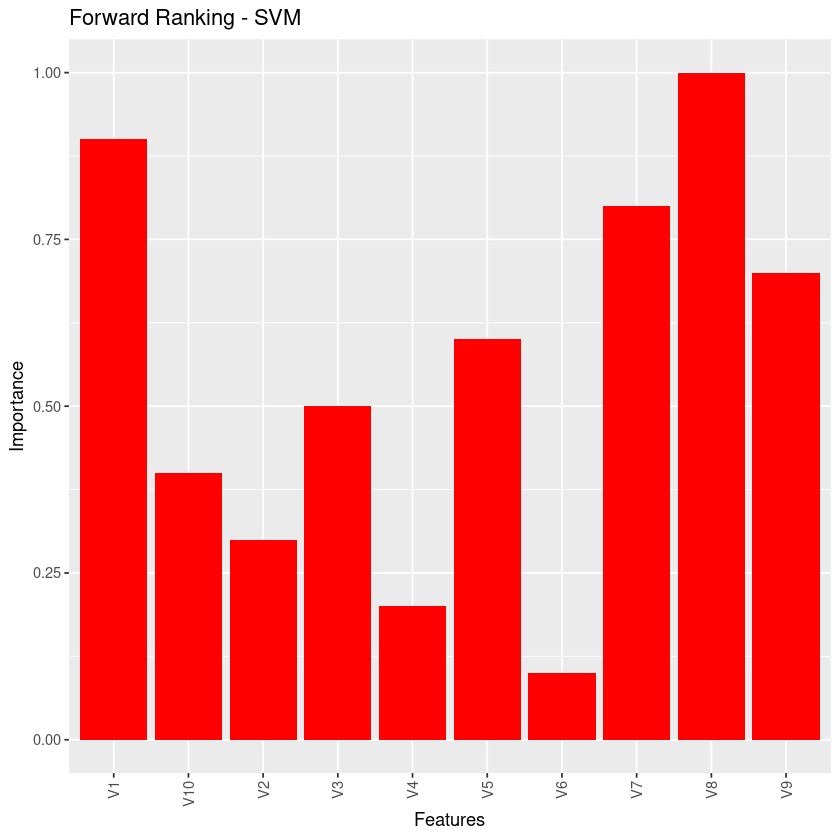

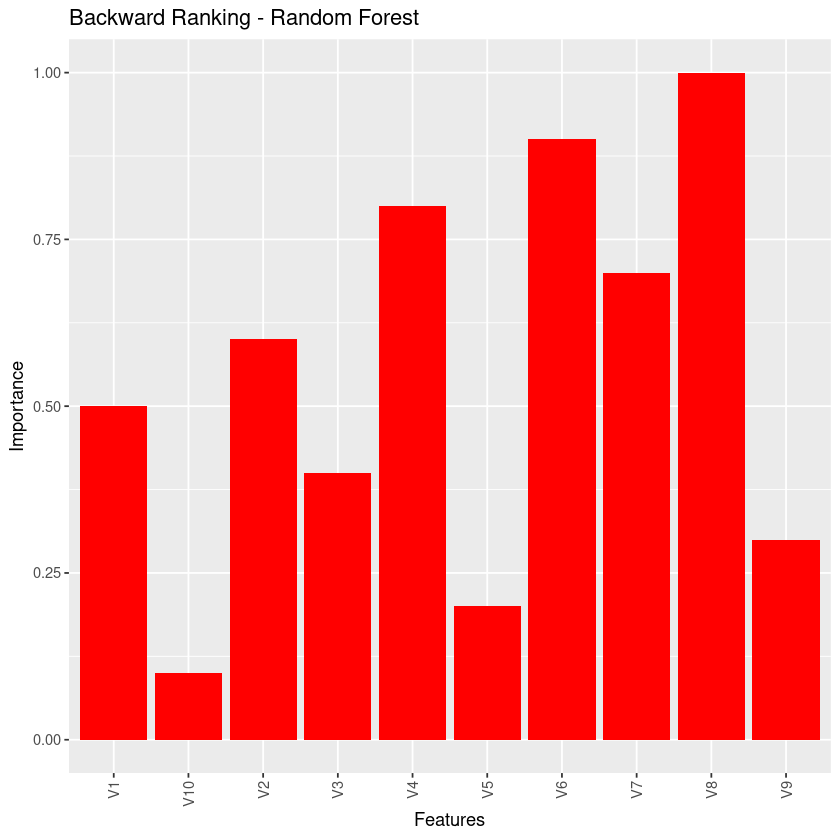

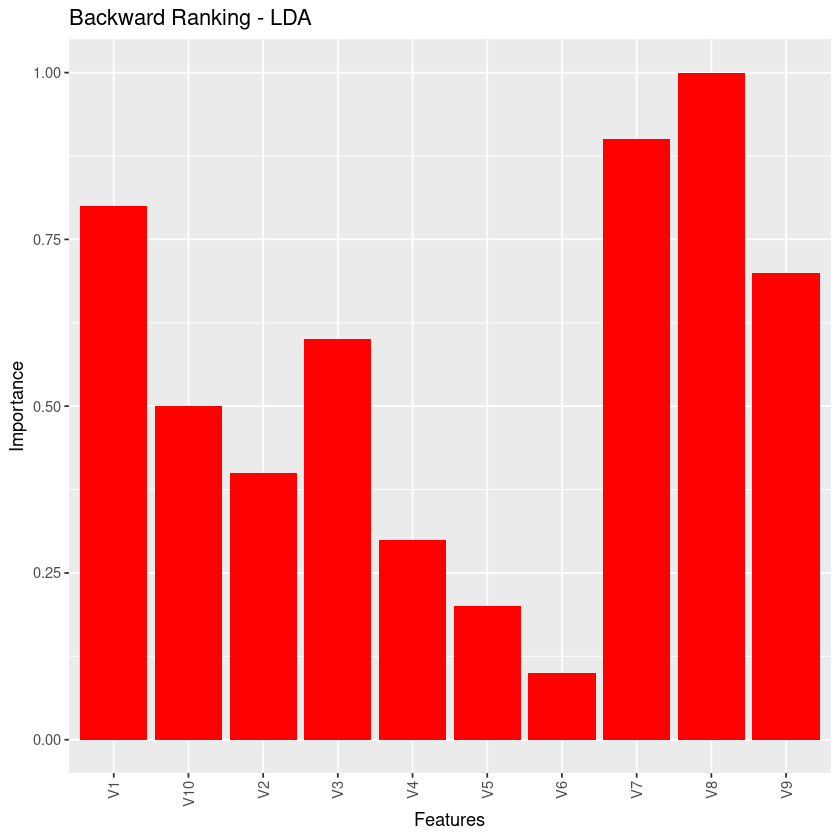

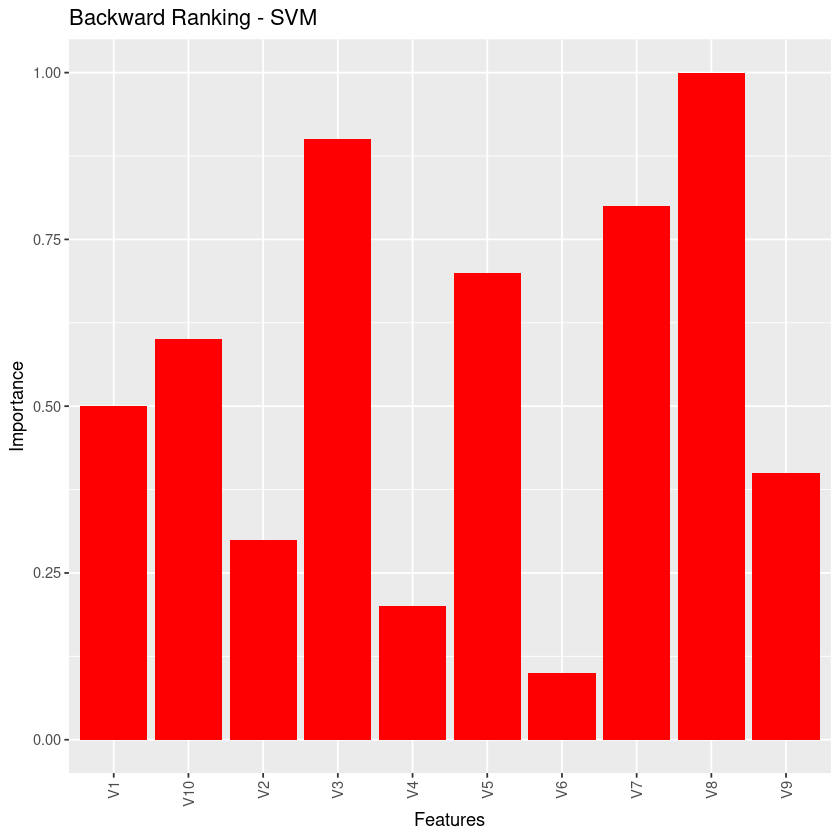

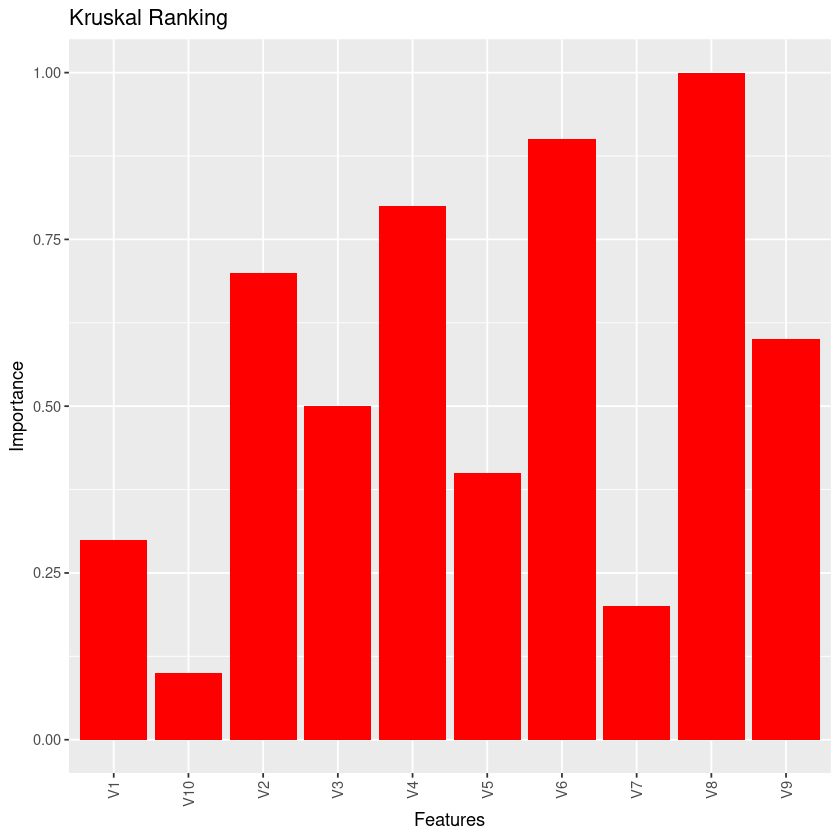

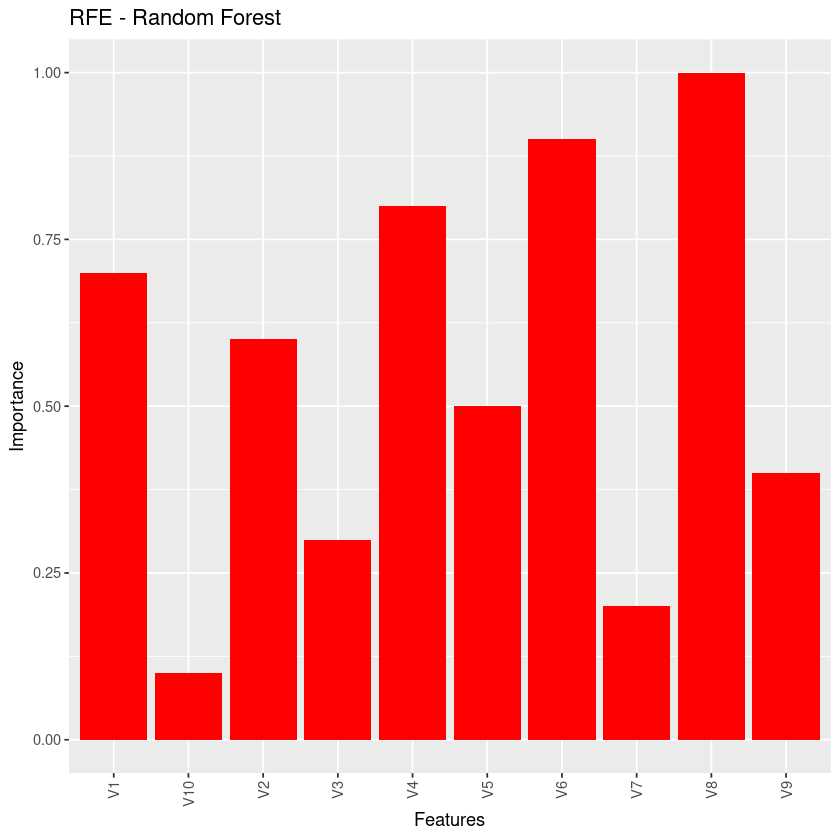

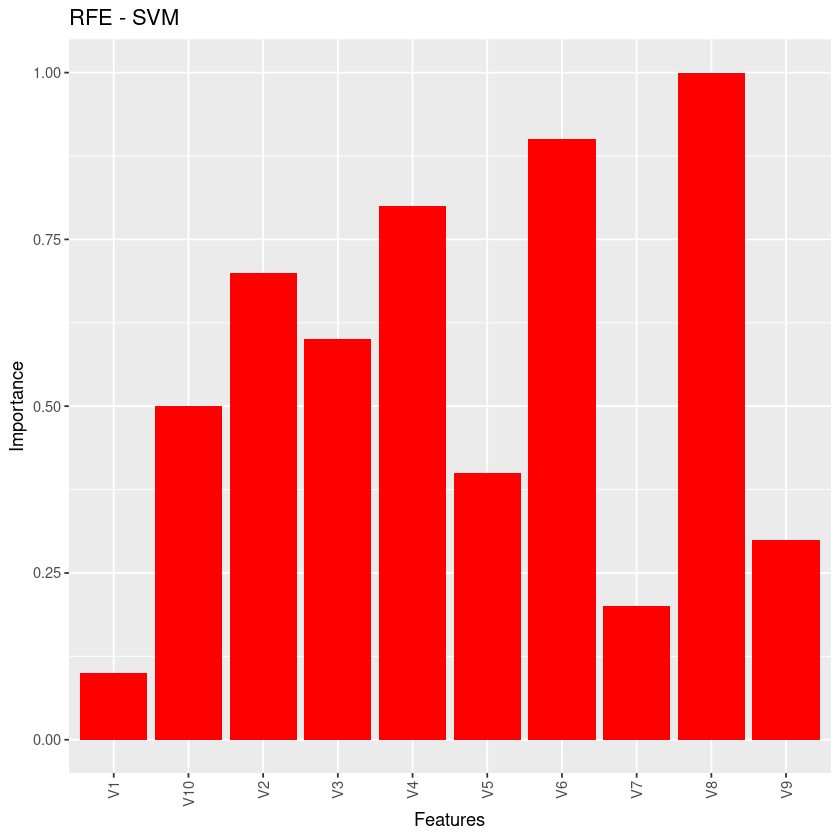

In [46]:
plot(datosA[, 1:feat.a], col = c("red", "blue")[as.numeric(classA)], pch = 16, cex = 0.5)

# make a bar graph where
# fr.rf.a$ordered.names.list is the X axis
# fr.rf.a$importance is the Y axis
# fr.rf.a$ordered.features.list is the x axis order
ggplot(data.frame(x = fr.rf.a$ordered.names.list, y = fr.rf.a$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Forward Ranking - Random Forest")

# make the same for fr.lda.a
ggplot(data.frame(x = fr.lda.a$ordered.names.list, y = fr.lda.a$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Forward Ranking - LDA")

# make the same for fr.svm.a
ggplot(data.frame(x = fr.svm.a$ordered.names.list, y = fr.svm.a$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Forward Ranking - SVM")

# make the same for br.rf.a
ggplot(data.frame(x = br.rf.a$ordered.names.list, y = br.rf.a$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Backward Ranking - Random Forest")

# make the same for br.lda.a
ggplot(data.frame(x = br.lda.a$ordered.names.list, y = br.lda.a$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Backward Ranking - LDA")

# make the same for br.svm.a
ggplot(data.frame(x = br.svm.a$ordered.names.list, y = br.svm.a$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Backward Ranking - SVM")

# make the same for kruskal.a
ggplot(data.frame(x = kruskal.a$ordered.names.list, y = kruskal.a$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Kruskal Ranking")

# make the same for rfe.rf.a
ggplot(data.frame(x = rfe.rf.a$ordered.names.list, y = rfe.rf.a$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("RFE - Random Forest")

# make the same for rfe.svm.a
ggplot(data.frame(x = rfe.svm.a$ordered.names.list, y = rfe.svm.a$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("RFE - SVM")


(Comentario, se que V10 esta entre V1 y V2, no encontre una forma de hacerlo bien y me resigné)

#### Datos A
En el caso de los DatosA, puedo notar facilmente que lo que se hizo en código quedó muy evidente gráficamente ya que la variable V8 se volvió la más importante. La variable V6 se aprecia un poco pero V4 y V2 se ven igual a ruido aleatorio. Me pareció raro que la combinacion de V8 y V4 o V8 y V2 den visualmente peores resultados que con las aleatorias.

Todos los métodos encontraron efectivamente a V8 como la variable más importante. En la mayoría de los casos V6, V4 y V2 le siguen como debería ser, excepto en algunos casos de FR y todos los casos de BR, no entiendo por qué.

Después de esa, el resto de variables oscilan mucho. También noto que V6 y V3 suelen intercambiar lugares (cuando una está entra las más importantes la otra es de las menos), esto debería significar que comparten la misma información pero me parece raro porque V3 es completamente aleatoria mientras que V6 debería representar el 20% de los datos sin error.

### Datos B

In [47]:
feat.b <- 8
trainB <- datosB[, 1:feat.b, drop = FALSE]
classB <- datosB[, feat.b + 1]

fr.rf.b <- forward.ranking(trainB, classB, method = "rf.est", tot.trees = 100, equalize.classes = F)
fr.lda.b <- forward.ranking(trainB, classB, method = "lda.est")
invisible(capture.output(fr.svm.b <- forward.ranking(trainB, classB, method = "svm.est")))
br.rf.b <- backward.ranking(trainB, classB, method = "rf.est", tot.trees = 100, equalize.classes = F)
br.lda.b <- backward.ranking(trainB, classB, method = "lda.est")
invisible(capture.output(br.svm.b <- backward.ranking(trainB, classB, method = "svm.est")))
kruskal.b <- kruskal.ranking(trainB, classB)
rfe.rf.b <- rfe.ranking(trainB, classB, method = "imp.rf")
invisible(capture.output(rfe.svm.b <- rfe.ranking(trainB, classB, method = "imp.linsvm")))


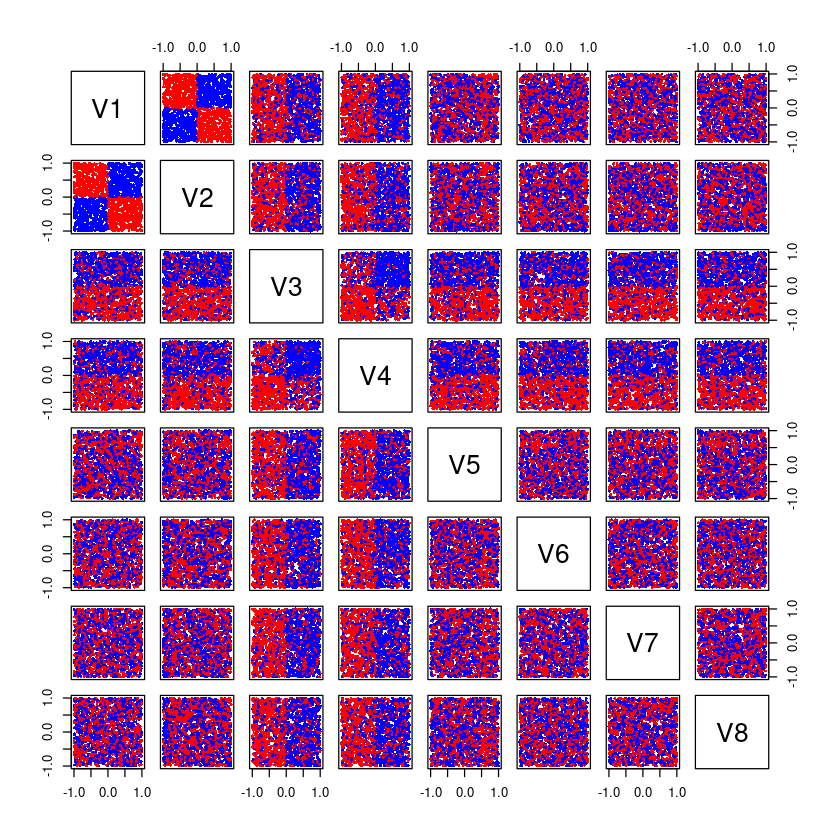

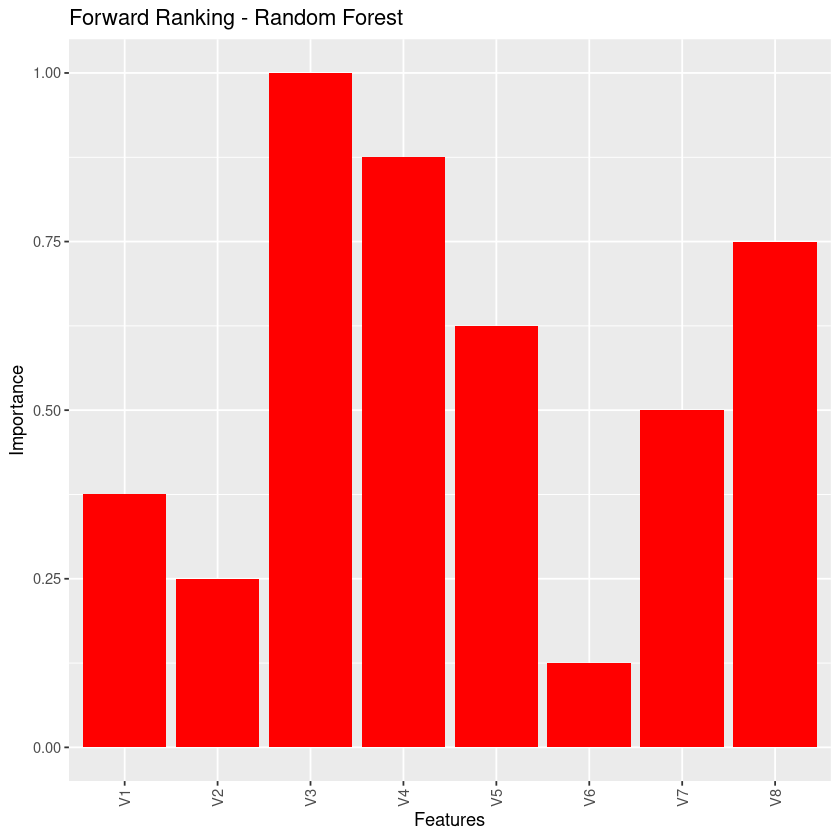

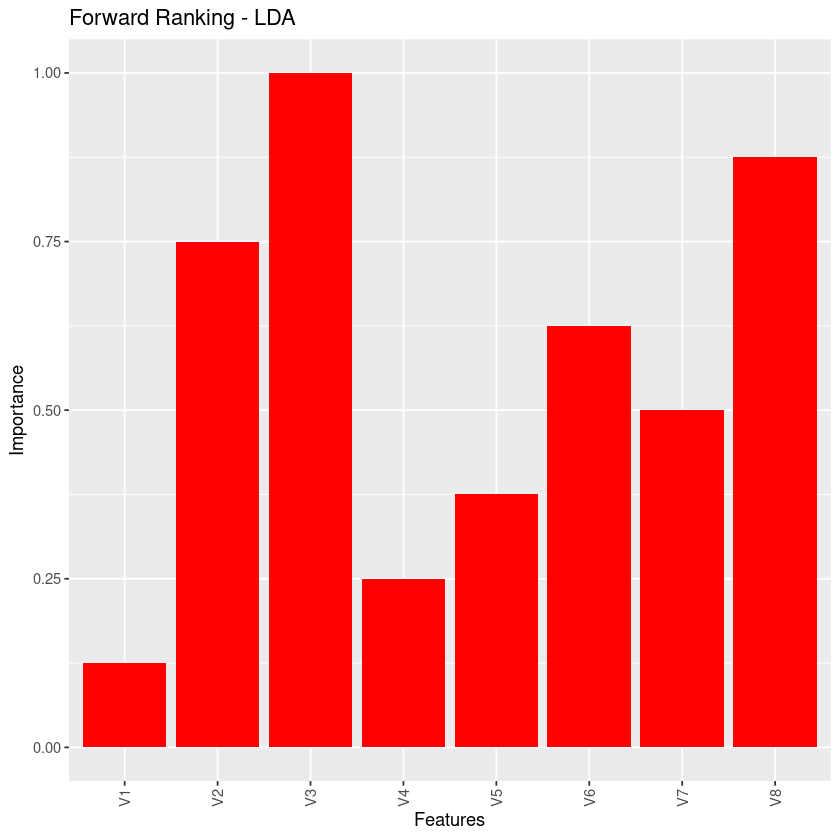

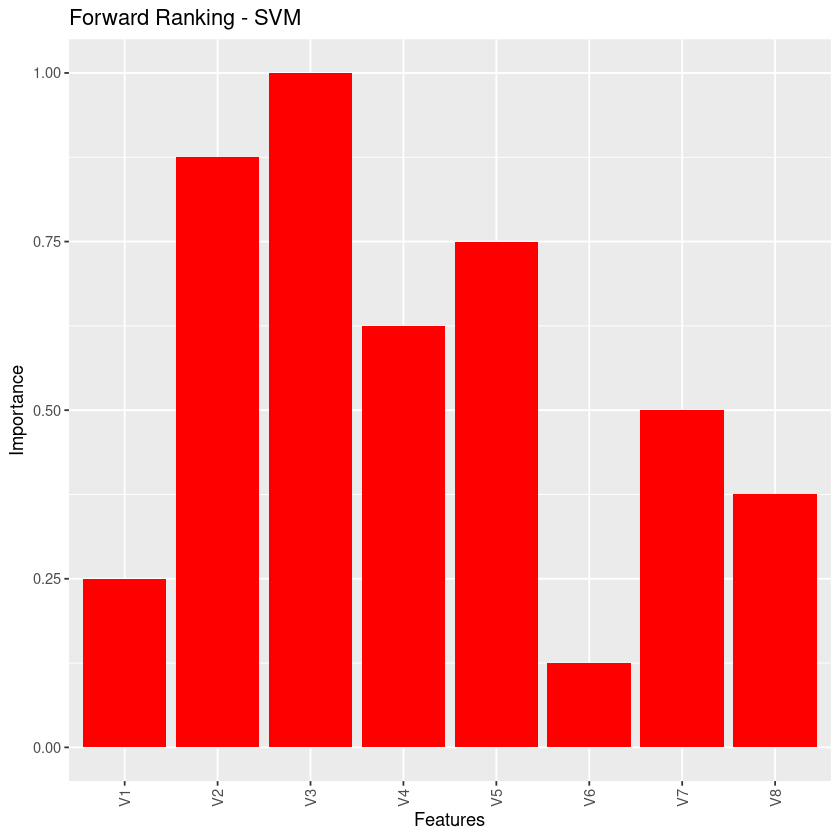

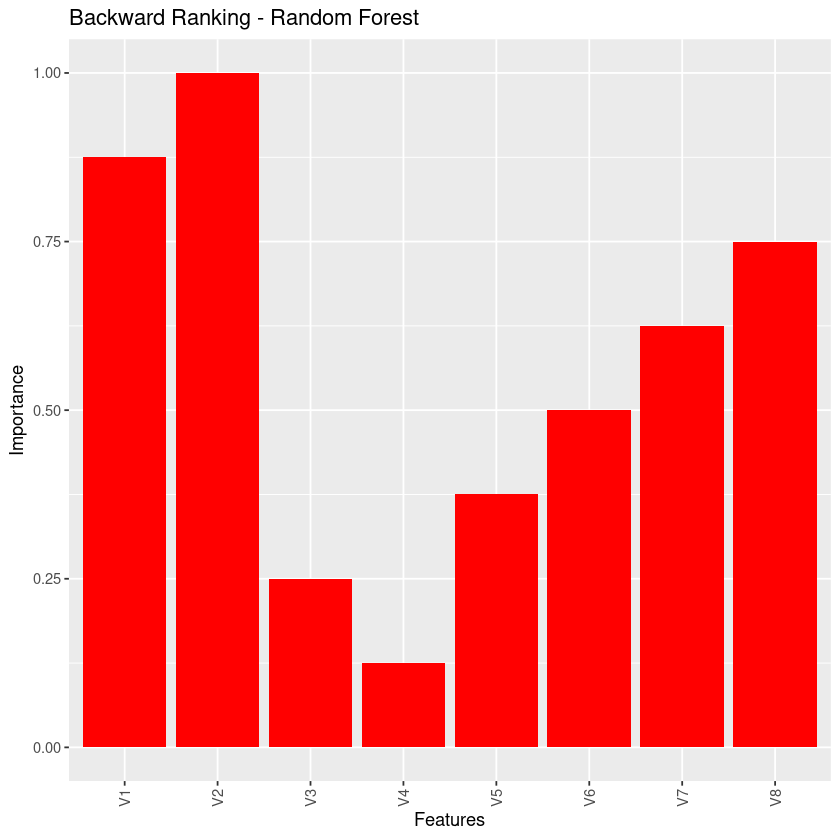

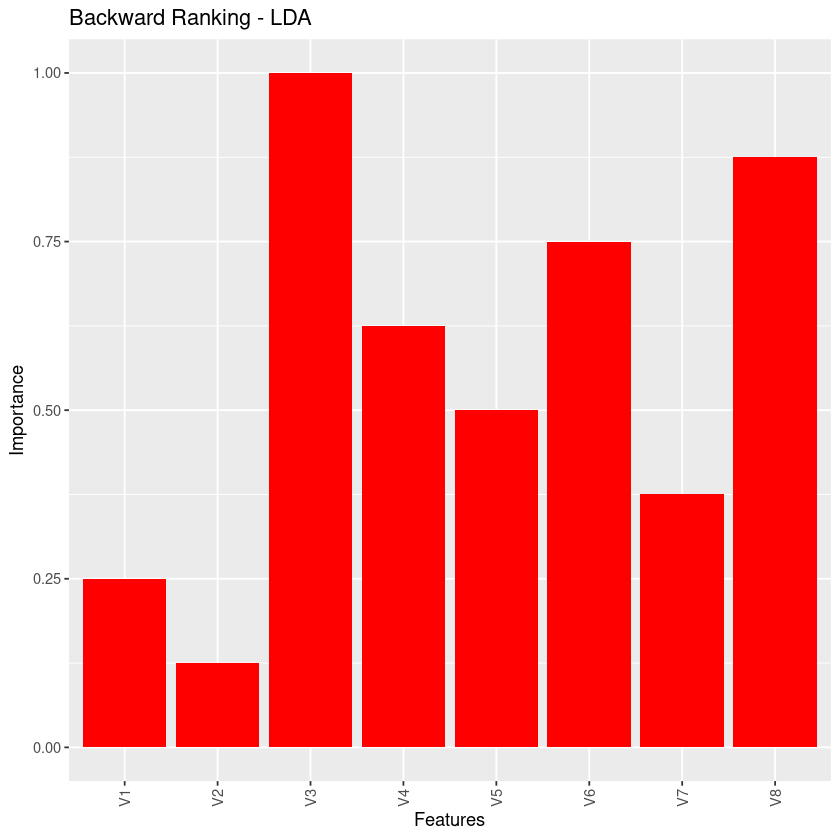

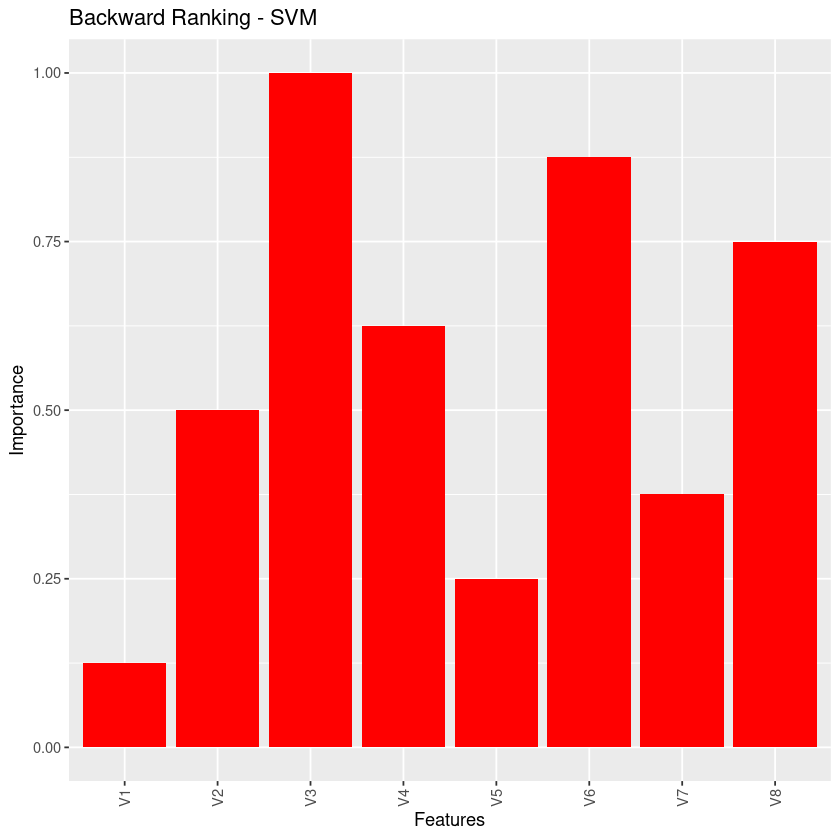

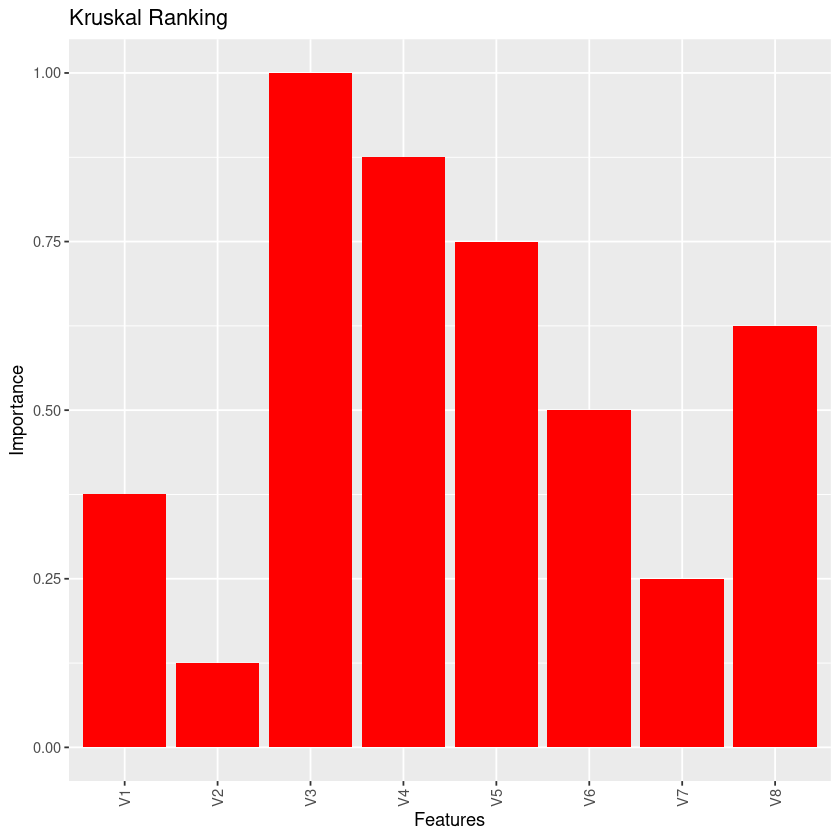

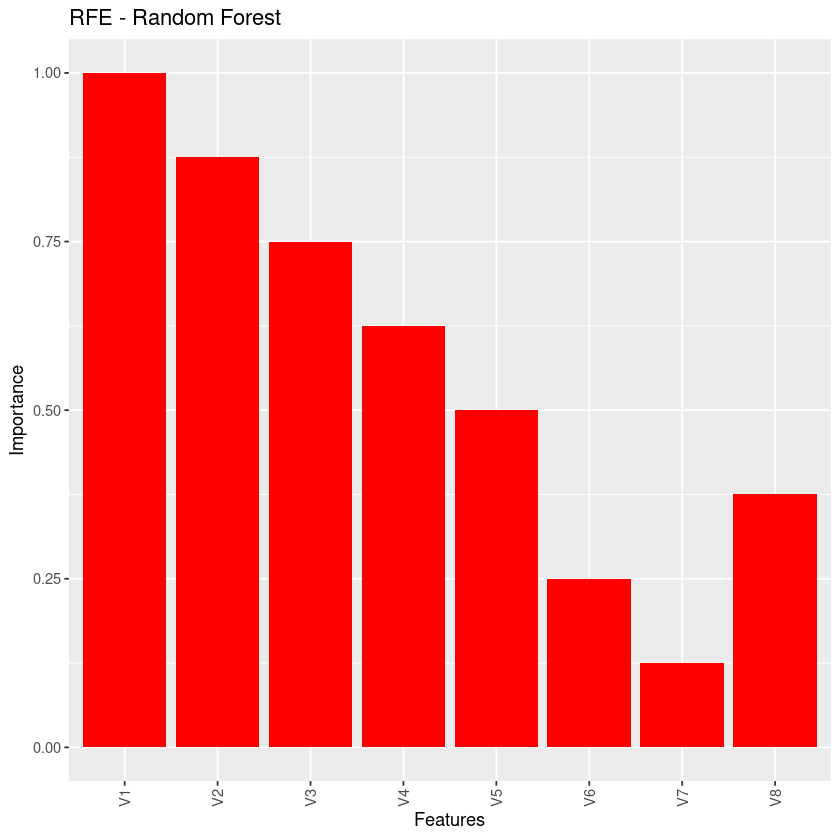

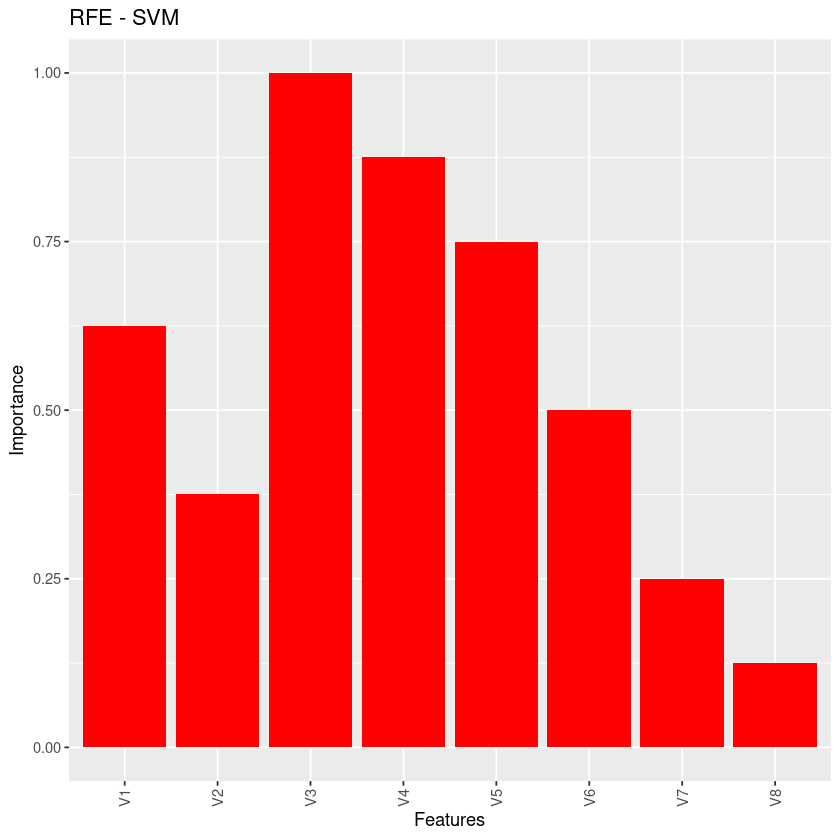

In [48]:
plot(datosB[, 1:feat.b], col = c("red", "blue")[as.numeric(classB)], pch = 16, cex = 0.5)

ggplot(data.frame(x = fr.rf.b$ordered.names.list, y = fr.rf.b$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Forward Ranking - Random Forest")

# make the same with fr.lda.b
ggplot(data.frame(x = fr.lda.b$ordered.names.list, y = fr.lda.b$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Forward Ranking - LDA")

# make the same with fr.svm.b
ggplot(data.frame(x = fr.svm.b$ordered.names.list, y = fr.svm.b$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Forward Ranking - SVM")

# make the same with br.rf.b
ggplot(data.frame(x = br.rf.b$ordered.names.list, y = br.rf.b$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Backward Ranking - Random Forest")

# make the same with br.lda.b
ggplot(data.frame(x = br.lda.b$ordered.names.list, y = br.lda.b$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Backward Ranking - LDA")

# make the same with br.svm.b
ggplot(data.frame(x = br.svm.b$ordered.names.list, y = br.svm.b$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Backward Ranking - SVM")

# make the same with kruskal.b
ggplot(data.frame(x = kruskal.b$ordered.names.list, y = kruskal.b$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("Kruskal Ranking")

# make the same with rfe.rf.b
ggplot(data.frame(x = rfe.rf.b$ordered.names.list, y = rfe.rf.b$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("RFE - Random Forest")

# make the same with rfe.svm.b
ggplot(data.frame(x = rfe.svm.b$ordered.names.list, y = rfe.svm.b$importance), aes(x = x, y = y)) +
    geom_bar(stat = "identity", fill = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Features", y = "Importance") +
    ggtitle("RFE - SVM")


#### Datos B
En el caso de los DatosB, Obviamente las más importantes deberían ser V1 y V2 ya uqe hacen un XOR de las clases. Me parece extraño que en backward ranking, donde deberían siempre quedar como las más importantes, solo lo hacen cuando utilizo el método de random forest. Los otros métodos terminan optando por V3 y V4 que si son importantes pero deberían generar manos error al descartarse. En kruskal y RFE-SVM encontró a V1 y V2 incluso menos importantes que las variables aleatorias, ¿puede ser que tenga algún error en mi código?

No puedo opinar del resto de variables porque son aleatorias, las variaciones en su importancia es pura casualidad.

# 3)

In [85]:
diagonal <- function(n, d, C) {
    # defino valores
    desv_est <- C * sqrt(d)
    mat_diag <- diag(desv_est, d, d)
    centro0 <- rep(-1, d)
    centro1 <- rep(1, d)
    cantidad0 <- floor(n / 2)
    cantidad1 <- n - cantidad0
    # genero puntos
    puntos0 <- mvrnorm(cantidad0, centro0, mat_diag)
    puntos1 <- mvrnorm(cantidad1, centro1, mat_diag)
    puntos <- rbind(puntos0, puntos1)
    # agrego clases
    colnames(puntos) <- paste("x", 1:d, sep = "") # appendea "x" al vector 1:d convertido en char
    clase <- c(rep(0, cantidad0), rep(1, cantidad1))
    puntos <- cbind(puntos, clase)
    return(as.data.frame(puntos))
}

crea.ruido.unif <- function(n = 100, d = 2) {
    x <- runif(2 * n * d, min = -1) # genero los datos
    dim(x) <- c(2 * n, d)
    return(cbind(as.data.frame(x), y = factor(rep(c(-1, 1), each = n)))) # le agrego la clase
}

In [89]:
generador <- function() {
    cantDatos <- 50
    datos <- diagonal(50 * 2, 10, 2)
    ruido <- crea.ruido.unif(50, 90)
    ruido <- ruido[, -91]
    datos <- cbind(datos[, -11], ruido, datos[, 11])
    colnames(datos) <- paste("x", 1:101, sep = "") # appendea "x" al vector 1:d convertido en char
    return(datos)
}


In [111]:
test <- generador()
test.data <- test[, -101]
test.class <- test[, 101]
print(dim(test.data))
print(length(test.class))
test.class

[1] 100 100
[1] 100


[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [116]:
# generador()
fr.rf.test <- forward.ranking(test.data, test.class, method = "rf.est", tot.trees = 100, equalize.classes = F)
# br.rf.test <- backward.ranking(test.data, test.class, method = "rf.est", tot.trees = 100, equalize.classes = F)

[1] 100 100
[1] 100
[1] 100   1
[1] 100


Warning message in randomForest.default(x.train, y, mtry = mtry, ntree = tot.trees, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


ERROR: Error in randomForest.default(x.train, y, mtry = mtry, ntree = tot.trees, : sampsize should be of length one
